Uses `langevin-survival.cpp` with `INPUT_DATA_FILE` flag to compute 2D MFPT from a file generated by `exp-data-diffus-analysis.ipynb`. The file contains $(x,y)$ positions, with only free diffusion phases, separated by `NaN`s when reset occurs. Parameters ($D$, $\sigma$, FPS, $T_\text{res}$...) are contained in the associated `.csv` file.

Things to specify in `langevin-survival.cpp` :
 - `#define INPUT_DATA_FILE` obviously
 - `#define XTARG_ONE_VARIABLE`
 - `#undef ENABLE_SURVIVAL_PROBABILITIES_*`
 - `#define TARGET_2D_CYL`

Then set `path_traj` and `path_params` below (outputs of `exp-data-diffus-analysis.ipynb`), and set desired $a$ and $b$'s in `a_and_b`. Because $T_r$ and $\sigma$ are fixed by the data, there is only one possibility for $L$ and $R_\text{tol}$, which will be set automatically.

Also choose how to define $\sigma$ from $(\sigma_x,\sigma_y)$ if they are different, typically $\sigma_x$ or $\sqrt{(\sigma_x^2+\sigma_y^2)/2}$ (the target being along the $x$ axis).

In [1]:
# [1]
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import pysimul
from common import *
from math import *

In [2]:
# [2]
path_params = "../dati_MFPT/20-01-10/qpd_Ttrap50ms_Ttot200ms_T0.03/qpd_Ttrap50ms_Ttot200ms_diffus.csv"
path_traj = "../dati_MFPT/20-01-10/qpd_Ttrap50ms_Ttot200ms_T0.03/qpd_Ttrap50ms_Ttot200ms_traj_data.bin"
df = pd.read_csv(path_params, sep=',', header=None)
df = df.set_index(0)
params = dict(df[1])
print(params)
D = params['D']
rT = params['reset_period']
σ = sqrt(params['sigma_x']**2 + params['sigma_y']**2)/sqrt(2) #params['sigma_x'] # or

reset_type = 'per'
path = "data-exp-2d-periodical/2D_meansigma/" # output storage directory
i_beg = 30

param_i = 0
a_and_b = [
    (0.3,1), (0.3,2), (0.3,3), (0.3,3.5), (0.3,4), (0.3,8),# (0.3,12),
    (0.5,1), (0.5,2), (0.5,3), (0.5,4), (0.5,6), (0.5,8),# (0.5,12),
    (0.6,2), (0.6,4), (0.6,12),
    (0.75,1), (0.75,2), (0.75,4), (0.75,8), (0.75,12),
    (0.9,2), (0.9,4), (0.9,8), (0.9,12),
]

{'N_traj': 249.0, 'ratio_x_y': 0.9828440944231122, 'sigma_x': 0.033886043718504996, 'sigma_y': 0.041104072050447436, 'D': 0.12108261098743794, 'D_err': 0.010740436099068912, 'fps': 50000.0, 'reset_period': 0.03}


In [101]:
# [3]
simul = pysimul.PySimul()

a,b = a_and_b[param_i]
print("doing a =",a,", b =",b)
assert(a < 1)
simul['first_times_xtarg'] = L = b*σ
simul['2D-Rtol'] = Rtol = a * L

simul['file_path'] = path_traj
simul.start()

if reset_type == 'poisson':
    th_tau_2d = fpt_2d_poisson_tau
    th_c = lambda L: fpt_poisson_c(α, D, L)
elif reset_type == 'per':
    th_tau_2d = np.vectorize(lambda b,c,a: fpt_2d_periodical_tau(b,c,a, use_cache="th-cache-2d-periodical/"))
    th_c = lambda L: fpt_periodic_c(rT, D, L)
c = th_c(L)

param_i += 1
ended = False

IndexError: list index out of range

In [4]:
# [4]
def timer_f ():
    global simul, ended
    if simul is None:
        return 1
    if simul['pause'] == 1 and not ended:
        ended = True
        return 2
    return 0

In [5]:
%%javascript
var sfml_event_poll_timer = setInterval(function() {
    Jupyter.notebook.kernel.execute("print(timer_f())", { iopub : { output : function (data) {
        console.log(data.content.text)
        if (data.content.text == "1\n" || data.content.text === undefined) {
            clearInterval(sfml_event_poll_timer);
        } else if (data.content.text == "2\n") {
            Jupyter.notebook.execute_cells([7,8,9,3]);
        }
    }}})
}, 1000);

<IPython.core.display.Javascript object>

In [6]:
# [6]
param_i-1, simul['n_trajectories']

(0, 12540)

In [98]:
# [7]
simul.explicit_lock()

time_conversion = (1/params['fps']) / simul['Delta_t']
first_times = simul['first_times'] * time_conversion
mfpt = np.mean(first_times)
n_traj = len(first_times)

path2 = path+str(param_i+i_beg)
np.savetxt(path2+"-ft.csv", first_times, fmt='%.2e')

d = {
    'D': D,
    'x0sigma': σ, 'x0sigma_x': params['sigma_x'], 'x0sigma_y': params['sigma_y'],
    'L': L, 'b': b, 'c': c,
    'Rtol': Rtol, 'a': a,
    'mfpt': mfpt, 'fpt_stdev': np.std(first_times),
    'n_traj': n_traj,
    'Delta_t': 1/params['fps'],
}

if reset_type == 'poisson':
    d['reset_rate'] = α
elif reset_type == 'per':
    d['reset_period'] = rT

df = pd.DataFrame(list(d.items())).set_index(0)
df.to_csv(path2+"-params.csv", header=False, quoting=csv.QUOTE_NONE, sep=',')
    
simul.explicit_unlock()
df.T

,D,x0sigma,x0sigma_x,x0sigma_y,L,b,c,Rtol,a,mfpt,fpt_stdev,n_traj,Delta_t,reset_period
1,0.121083,0.037668,0.033886,0.041104,0.45202,12.0,3.749957,0.406818,0.9,0.027147,0.032592,22556.0,0.00002,0.03


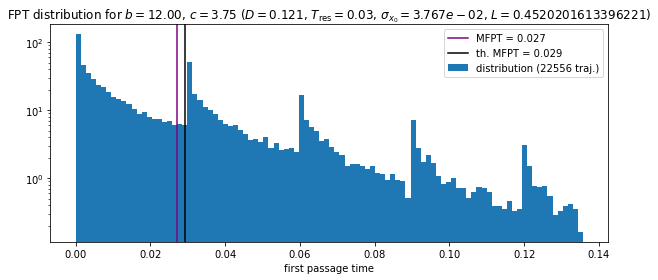

In [99]:
# [8]
plt.figure(figsize=(10,4))
fpt_max = 5*mfpt
plt.hist(first_times, bins=100, range=(0,fpt_max), weights=100/fpt_max*np.ones(n_traj)/n_traj, label="distribution ({} traj.)".format(n_traj))
plt.axvline(x=mfpt, color='purple', label="MFPT = {:.3f}".format(mfpt))

# comment if not wanted :
mfpt_th = L**2/(4*D)*th_tau_2d(b,c,a)
plt.axvline(x=mfpt_th, color='black', label="th. MFPT = {:.3f}".format(mfpt_th))

plt.yscale('log')
plt.xlabel("first passage time")
if reset_type == 'poisson':
    plt.title(r"FPT distribution for $b={:.2f}$, $c={:.2f}$ ($D={:.3f}$, $\alpha={}$, $\sigma_{{x_0}}={:.3e}$, $L={}$)".format(b, c, D, α, σ, L))
elif reset_type == 'per':
    plt.title(r"FPT distribution for $b={:.2f}$, $c={:.2f}$ ($D={:.3f}$, $T_\operatorname{{res}}={}$, $\sigma_{{x_0}}={:.3e}$, $L={}$)".format(b, c, D, rT, σ, L))
plt.legend()
plt.savefig(path2+"-distrib.pdf", bbox_inches='tight')

In [100]:
# [9]
simul.end()